In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# os.remove("/kaggle/working/best_basic_model.keras")

# Introduction - CNN Cancer Detection

In this notebook, we will be working with the Histopathologic Cancer Detection dataset from Cukierski (2018), which is a modified subset of PatchCamelyon (PCam) with all duplicates removed. The goal of this project is to train a model that can predict whether the center 32×32 pixel region of an image patch contains at least one pixel of tumor tissue.

The project includes problem explanation, exploratory data analysis (EDA), data preprocessing, model building, hyperparameter tuning, results analysis, and conclusion.



# Part 1 -  Description of the problem and data

**The Problem**

The objective is to classify histopathologic images as either cancerous (label = 1) or non-cancerous (label = 0) by analyzing a 32×32 pixel region within each 96×96 pixel image. The dataset includes over 220,000 training images and 57,000 test images in .tif format. This is a binary classification task that involves training a deep learning model to accurately identify cancerous areas.

**The Data**

The dataset is composed by:

- Training Labels: A CSV file (train_labels.csv) containing image IDs along with corresponding binary labels — 1 for cancerous and 0 for non-cancerous.

- Training Images: Around 220,000 RGB images, each sized 96×96 pixels, stored in the train directory.

- Test Images: Roughly 57,000 unlabeled images of the same size and format, located in the test directory.

- Labeling Focus: Each label refers specifically to the presence or absence of tumor tissue in the central 32×32 region of the image.








# Part 2 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

We now want to understand the data more. Let's start by exploring some basic data description.

In [3]:
# Define the paths for data
data_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_labels_path = os.path.join(data_dir, 'train_labels.csv')
train_images = os.path.join(data_dir, 'train')
test_images = os.path.join(data_dir, 'test')

# Load the labels
train_labels = pd.read_csv(train_labels_path)

# Data description
print(f"Train labels shape: {train_labels.shape}")
print("\nDistribution of the labels:")
print(train_labels['label'].value_counts())
print("\nFirst 5 rows of training labels:")
print(train_labels.head())
print("\nMissing values:")
print(train_labels.isnull().sum())

Train labels shape: (220025, 2)

Distribution of the labels:
label
0    130908
1     89117
Name: count, dtype: int64

First 5 rows of training labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Missing values:
id       0
label    0
dtype: int64


We also want to visualize the label distribution to see if there is any possible imbalance.



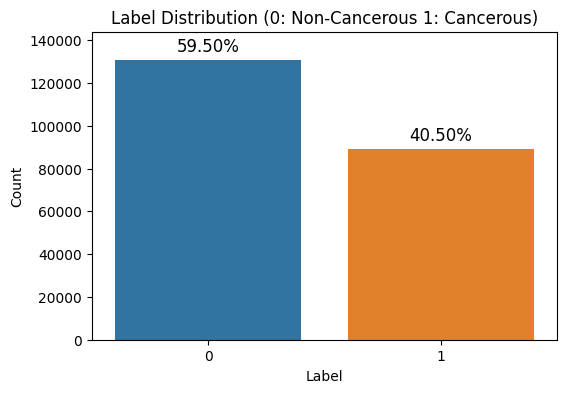

In [4]:
label_counts = train_labels['label'].value_counts()
total = len(train_labels)

# Visualize
plt.figure(figsize=(6,4))
ax = sns.countplot(data=train_labels, x='label')

for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + total * 0.01, percent, ha='center', va='bottom', fontsize=12)

plt.title("Label Distribution (0: Non-Cancerous 1: Cancerous)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, label_counts.max() * 1.1)
plt.show()

We can determine the actual dimensions of an image by using its 'shape' attribute, which provides the width, height, and number of channels (RGB).

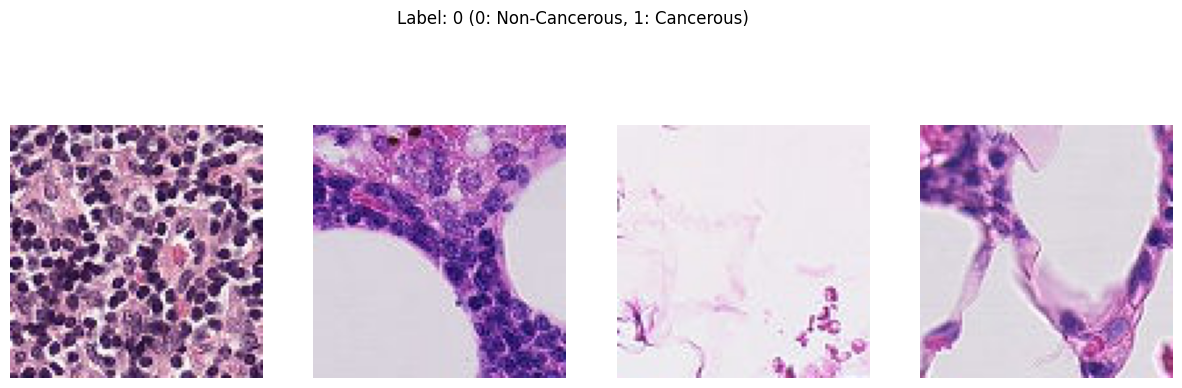

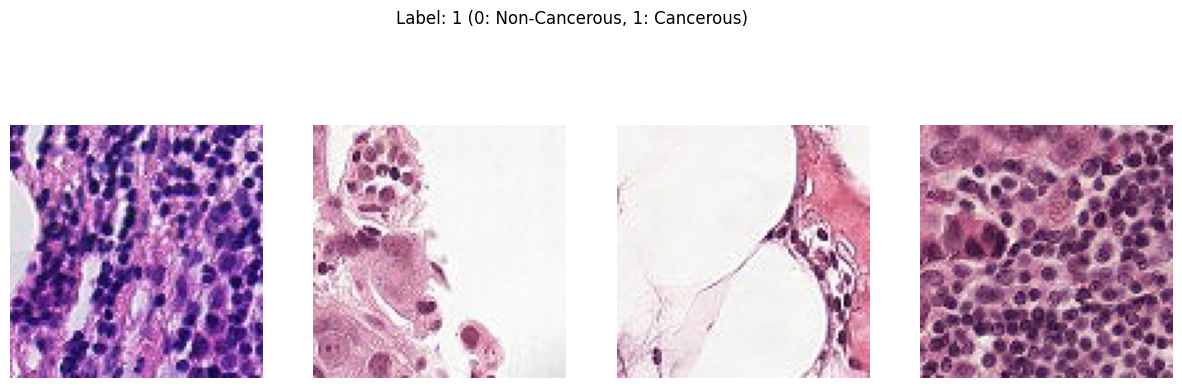

Image shape: (96, 96, 3)


In [5]:
def load_images(image_id, base_path='/kaggle/input/histopathologic-cancer-detection/train'):
    path = os.path.join(base_path, f"{image_id}.tif")
    return cv2.imread(path)

def show_samples(train_labels, label, n=4):
    samples = train_labels[train_labels['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        img = load_images(img_id)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Label: {label} (0: Non-Cancerous, 1: Cancerous)")
    plt.show()

show_samples(train_labels, label=0)
show_samples(train_labels, label=1)

img = load_images(train_labels['id'][0])
print("Image shape:", img.shape)

**EDA Summary: Insights & Data Cleaning**

***Label Distribution***
* The dataset consists of approximately 60% non-cancerous (label=0) and 40% cancerous (label=1) images.
* This indicates a moderate class imbalance, which might affect model performance, especially in terms of recall and precision for the minority class (cancerous).
* We'll consider using class weighting, balanced sampling, or augmentation for label=1 during training.

***Data Integrity***
* No missing values were found in the train_labels.csv.

* All image IDs in the CSV appear valid and point to existing .tif files.

***Visual Inspection***

* Sample images from both classes are visually diverse.

* Cancerous patches don't always show clearly distinct features, which means the model will need to learn subtle texture or color patterns.

* Non-cancerous samples sometimes contain tissue that looks similar to cancerous ones, so false positives could be an issue.

***Need for Data Cleaning?***

No major cleaning needed:

* Labels are binary and well-defined.

* Image files are accessible and not corrupted (at least in the samples tested).

# Part 3 - Data Preprocessing & Plan of Analysis


**Splitting the dataset**

Before training our models, we need to split the data into training and validation sets. To avoid overloading Kaggle’s memory, we first take a smaller sample of the dataset. I chose 30,000 samples to keep the process faster and more manageable during model development. Using this sampled data, we then create the train/validation split to prepare for training.

**To prepare for image import, we add a column for the full filename (including the extension) and convert the label to a string format.**

In [6]:
train_labels['label_str'] = train_labels['label'].astype(str)
train_labels['filename'] = train_labels['id'] + '.tif'

In [7]:
from sklearn.model_selection import train_test_split

# Sample 30,000 entries from train_labels, keeping label distribution balanced
df_sampled, _ = train_test_split(
    train_labels,
    train_size=30000,
    stratify=train_labels['label'],
    random_state=42
)

# Split sampled data into training (80%) and validation (20%) sets with stratification
train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,                      # 20% reserved for validation
    stratify=df_sampled['label'],       # maintain class balance in splits
    random_state=42                     # ensure reproducibility
)

# Show label distribution to confirm balance in training and validation sets
print("Train label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))

Train label distribution:
label
0    0.594958
1    0.405042
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.595
1    0.405
Name: proportion, dtype: float64


**Load, resize, convert, and normalize images, then create TensorFlow datasets using a custom generator for efficient training and validation.**

In [8]:
import cv2
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_SIZE = (96, 96)

def preprocess_image(image_path):
    # Load the image in BGR format
    image = cv2.imread(image_path)
    # Resize to fixed size
    image = cv2.resize(image, IMAGE_SIZE)
    # Convert BGR to RGB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0
    return image

def create_data_generator(image_paths, labels):
    for img_path, lbl in zip(image_paths, labels):
        img = preprocess_image(img_path)
        yield img, lbl

# Prepare file paths and labels for training and validation sets
train_image_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{filename}" for filename in train_df['filename']]
train_labels = train_df['label'].values.astype(np.float32)

val_image_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{filename}" for filename in val_df['filename']]
val_labels = val_df['label'].values.astype(np.float32)

# Create TensorFlow datasets using your generator function
train_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(train_image_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1000).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(val_image_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


2025-06-18 02:34:02.533178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750214042.556309      84 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750214042.563213      84 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750214046.547752      84 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Data sanity check**

In [9]:
# Take one batch from the training dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("First label in batch:", labels[0].numpy())
    break

Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)
First label in batch: 1.0


# Part 4 - Model Architecture

We will use both the basic model and the VGG model for the model architecture section. These models will help us compare simple versus more complex convolutional neural networks. This approach allows us to understand their performance differences on our dataset.

**Model 1: Basic Model with Batch Normalization**

This is a simple convolutional neural network that gradually extracts features from images using convolutional layers. It uses batch normalization and max pooling to stabilize training and reduce spatial size. The model ends with dense layers to perform binary classification.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_basic_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ], name="Basic_CNN_Model")
    return model

basic_model = build_basic_cnn()
basic_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Basic_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 36864)               │         147,456 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,097 (797.25 KB)

 Trainable params: 130,177 (508.50 KB)

 Non-trainable params: 73,920 (288.75 KB)

**Model 2: VGGNet**


This model is inspired by the VGG architecture and uses multiple convolutional layers per block to learn more complex features. Batch normalization is applied after each convolution to improve training stability. Max pooling layers reduce spatial dimensions progressively. Dense layers at the end perform binary classification based on the extracted high-level features.

In [11]:
def build_vgg_like(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ], name="vgg_like_model")
    return model

vgg_model = build_vgg_like()
vgg_model.summary()

Model: "vgg_like_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,007,905 (19.10 MB)

 Trainable params: 5,007,009 (19.10 MB)

 Non-trainable params: 896 (3.50 KB)

# Part 5 - Results and Analysis

We will start by training the basic CNN model and evaluating it using the confusion matrix, AUC, and false negative rate, which is critical for medical data. Then, we apply the same process to the VGG-style model to compare performance. Finally, we tune the best model's optimizer, loss function, and other settings. All models use a fixed steps per epoch for consistent training.


In [12]:
import tensorflow as tf
from tensorflow.keras import callbacks

# Compile the model
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(filepath='best_basic_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

bm_history = basic_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=2
)

basic_model.evaluate(val_dataset, steps=validation_steps)


Epoch 1/10


I0000 00:00:1750214063.292005     135 service.cc:148] XLA service 0x7f5798026600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750214063.293202     135 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750214063.710254     135 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750214066.660361     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.71942, saving model to best_basic_model.keras
750/750 - 323s - 431ms/step - accuracy: 0.7312 - loss: 1.2132 - val_accuracy: 0.7194 - val_loss: 1.2784 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.71942
750/750 - 38s - 51ms/step - accuracy: 0.7449 - loss: 1.3917 - val_accuracy: 0.6765 - val_loss: 4.0790 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy improved from 0.71942 to 0.74983, saving model to best_basic_model.keras
750/750 - 37s - 50ms/step - accuracy: 0.7540 - loss: 1.2019 - val_accuracy: 0.7498 - val_loss: 1.8140 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy improved from 0.74983 to 0.80331, saving model to best_basic_model.keras
750/750 - 37s - 49ms/step - accuracy: 0.7648 - loss: 0.8920 - val_accuracy: 0.8033 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.80331
750/750 - 36s - 48ms/step - accuracy: 0.7811 - loss: 0.6941 -

[0.4749804735183716, 0.814338207244873]

After running the first basic model, we can plot the accuracy and loss history.

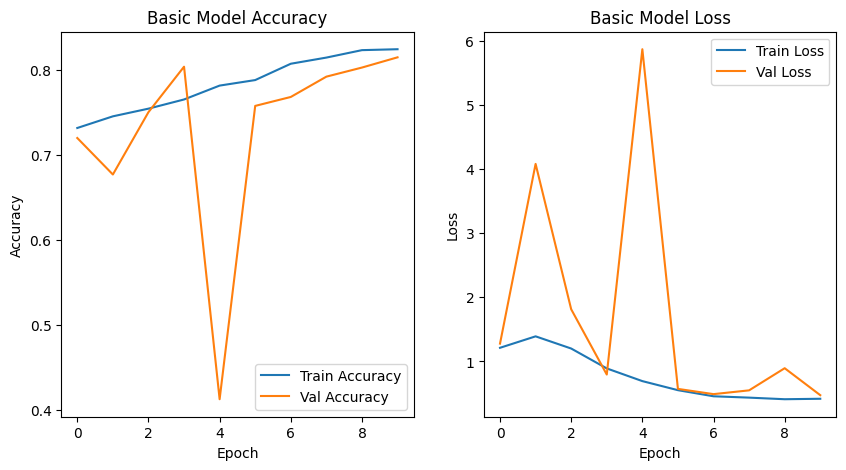

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(bm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Basic Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bm_history.history['loss'], label='Train Loss')
plt.plot(bm_history.history['val_loss'], label='Val Loss')
plt.title('Basic Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model is learning, as shown by the overall upward trend in validation accuracy. However, the fluctuations suggest unstable training, which could be caused by a high learning rate, a small or noisy validation set, or slight overfitting. To improve stability, we can continue training with early stopping, allow the learning rate scheduler to adjust, and consider adding dropout or other regularization techniques. 

Next we want to get the predicted and true values for the labels which is useful for creating confusion matrix and AUC.

In [14]:
import numpy as np

def get_y_true_and_y_pred(val_dataset, model, threshold=0.5):
    y_true = []
    y_pred_probs = []

    for batch_x, batch_y in val_dataset:
        preds = model.predict(batch_x, verbose=0)
        y_pred_probs.extend(preds.ravel())  # Flatten predicted probabilities
        y_true.extend(batch_y.numpy().ravel())  # Convert labels from tensor to NumPy array

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > threshold).astype(int)

    return y_true, y_pred, y_pred_probs

In [15]:
y_true_bm, y_pred_bm, y_pred_probs_bm = get_y_true_and_y_pred(val_dataset, basic_model, threshold=0.5)

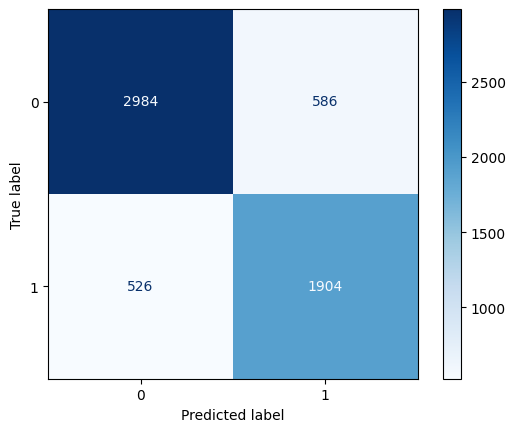

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_bm, y_pred_bm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

The confusion matrix shows that there are a decent amount of false negatives, which is not great for medical projects since every prediction will matter a lot.

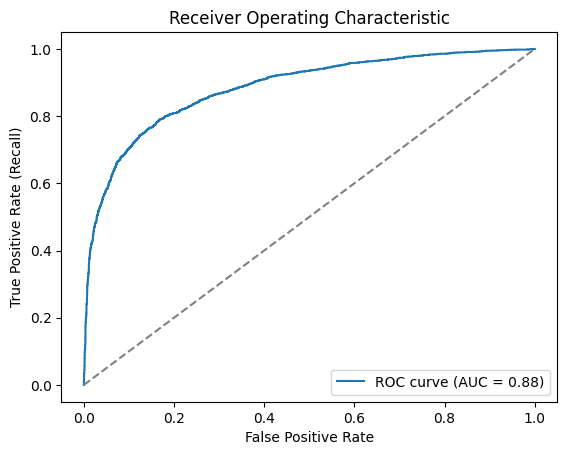

In [17]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_true_bm, y_pred_probs_bm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The ROC curve plot shows that the AUC is 0.88.

In [18]:
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

callbacks_list_vgg = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_vgg_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

vgg_history = vgg_model.fit(
    train_dataset,  
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list_vgg,
    verbose=2
)

vgg_model.evaluate(val_dataset, steps=validation_steps)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.79830, saving model to best_vgg_model.keras
750/750 - 50s - 67ms/step - accuracy: 0.7824 - loss: 0.7773 - val_accuracy: 0.7983 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.79830
750/750 - 37s - 50ms/step - accuracy: 0.8283 - loss: 0.4152 - val_accuracy: 0.7579 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.79830
750/750 - 45s - 60ms/step - accuracy: 0.8407 - loss: 0.3898 - val_accuracy: 0.7744 - val_loss: 0.8080 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy improved from 0.79830 to 0.85294, saving model to best_vgg_model.keras
750/750 - 44s - 58ms/step - accuracy: 0.8397 - loss: 0.3744 - val_accuracy: 0.8529 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.85294
750/750 - 39s - 53ms/step - accuracy: 0.8619 - loss: 0.3388 - val_accuracy: 0.7913 - val_loss: 0.482

[0.35765692591667175, 0.8529411554336548]

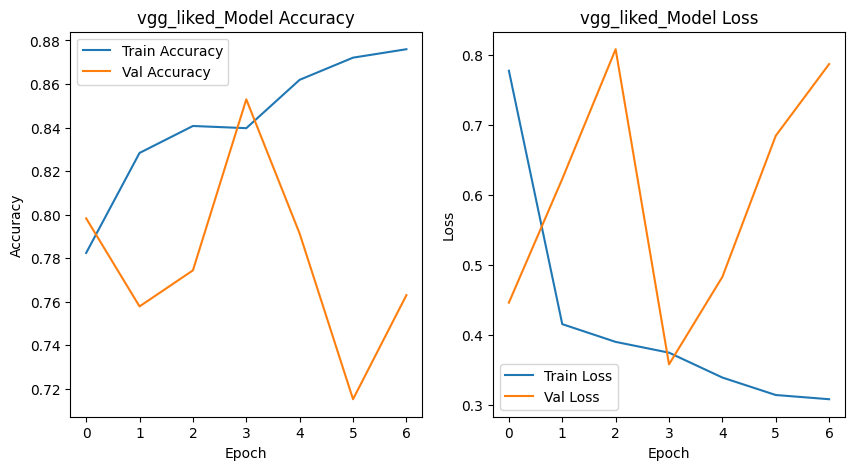

In [19]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('vgg_liked_Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('vgg_liked_Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
y_true_vgg, y_pred_vgg, y_pred_probs_vgg = get_y_true_and_y_pred(val_dataset, vgg_model, 0.5)

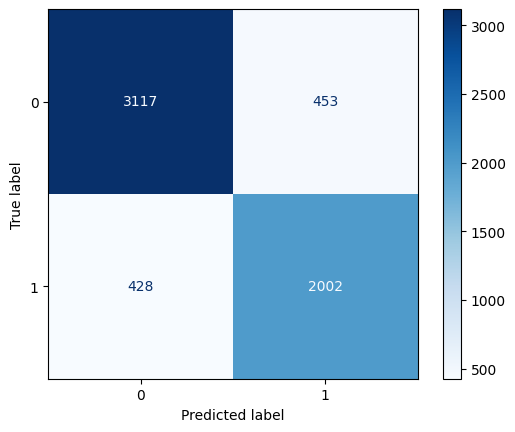

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

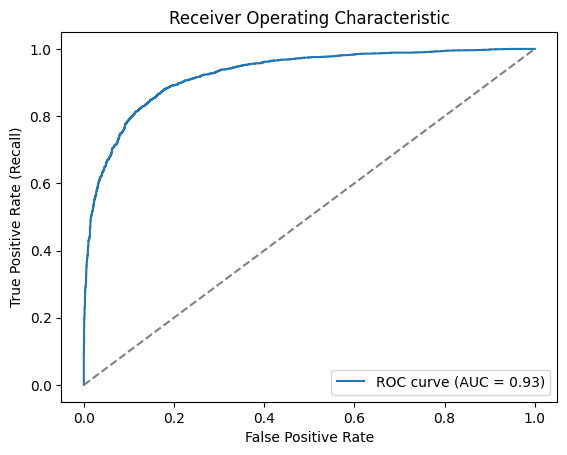

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Tuning Parameter: VGGNet Model - Learning Rate


In [23]:
# Create TensorFlow datasets using your generator function
train_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(train_image_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1000).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(val_image_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Use a lower learning rate for fine-tuning
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the VGG model
vgg_model.compile(
    optimizer=new_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Compute steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

# Train the model
vgg_history_v2 = vgg_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=2
)

# Evaluate the model
vgg_model.evaluate(val_dataset, steps=validation_steps)


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.88770, saving model to best_vgg_model_v1.keras
750/750 - 57s - 76ms/step - accuracy: 0.8771 - loss: 0.2950 - val_accuracy: 0.8877 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.88770 to 0.89739, saving model to best_vgg_model_v1.keras
750/750 - 39s - 52ms/step - accuracy: 0.8907 - loss: 0.2683 - val_accuracy: 0.8974 - val_loss: 0.2542 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.89739
750/750 - 36s - 49ms/step - accuracy: 0.9000 - loss: 0.2444 - val_accuracy: 0.8705 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy improved from 0.89739 to 0.89856, saving model to best_vgg_model_v1.keras
750/750 - 36s - 48ms/step - accuracy: 0.9078 - loss: 0.2285 - val_accuracy: 0.8986 - val_loss: 0.2701 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy improved from 0.89856 to 0.90307, saving model to best_vgg_mod

[0.2541511356830597, 0.8973930478096008]

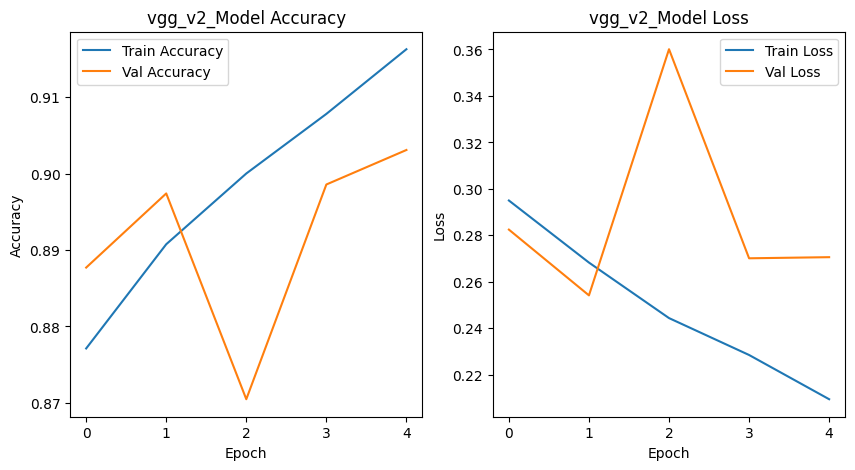

In [25]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('vgg_v2_Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v2.history['loss'], label='Train Loss')
plt.plot(vgg_history_v2.history['val_loss'], label='Val Loss')
plt.title('vgg_v2_Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Tuning Parameter: VGGNet Model - L2 Regularization

In [26]:
from tensorflow.keras import regularizers

def build_vgg_like_l2(input_shape=(96, 96, 3), l2_lambda=1e-4):
    l2 = regularizers.l2(l2_lambda)

    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name="vgg_like_l2")
    
    return model

vgg_model_l2 = build_vgg_like_l2()
vgg_model_l2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "vgg_like_l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,007,905 (19.10 MB)

 Trainable params: 5,007,009 (19.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
# Create TensorFlow datasets using your generator function
train_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(train_image_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1000).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


val_dataset = tf.data.Dataset.from_generator(
    lambda: create_data_generator(val_image_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [28]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
vgg_model_l2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Compute steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

# Set callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_l2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
vgg_history_l2 = vgg_model_l2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7667 - loss: 0.6669
Epoch 1: val_accuracy improved from -inf to 0.82670, saving model to best_vgg_model_l2.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - accuracy: 0.7667 - loss: 0.6668 - val_accuracy: 0.8267 - val_loss: 0.4770 - learning_rate: 1.0000e-04
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8263 - loss: 0.4812
Epoch 2: val_accuracy improved from 0.82670 to 0.84057, saving model to best_vgg_model_l2.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8264 - loss: 0.4812 - val_accuracy: 0.8406 - val_loss: 0.4503 - learning_rate: 1.0000e-04
Epoch 3/10
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8441 - loss: 0.4482
Epoch 3: val_accuracy improved from 0.84057 to 0.85127, saving model to best_vgg_model_l2.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.8441 - loss: 0.4482 - val_accuracy: 0.8513 - val_loss: 0.4258 - learning_rate: 1.0000e-04
Epoch 4/10
75

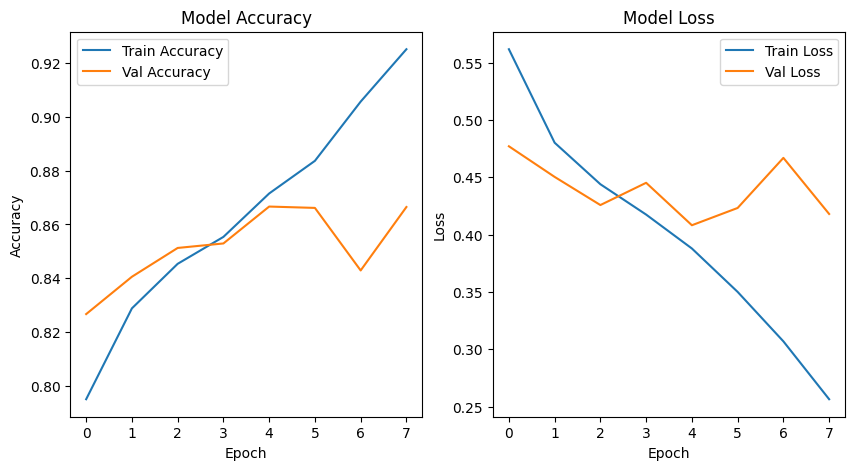

In [29]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_l2.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_l2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_l2.history['loss'], label='Train Loss')
plt.plot(vgg_history_l2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

We can observe that the validation accuracy increases alongside the training accuracy, and the same trend appears in the loss values. This parallel movement indicates that our final tuning was effective. However, the presence of multiple spikes suggests the training process is still quite noisy and unstable at times.

In [30]:
y_true_vgg, y_pred_vgg, y_pred_probs_vgg = get_y_true_and_y_pred(val_dataset, vgg_model_l2, 0.5)

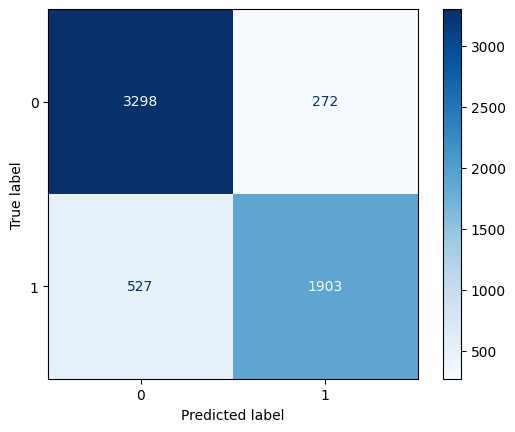

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

We have reduced a few of the false negatives, but there are still plenty, which signify that this would still not be good enough for medical purposes.



In [32]:
import os
import pandas as pd

# Get all .tif filenames from the test folder
test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".tif")])

# Extract IDs by removing ".tif"
test_ids = [f[:-4] for f in test_filenames]

In [33]:
import tensorflow as tf
import cv2
import numpy as np
import os

def load_image_cv2(path, target_size=(96, 96)):
    img = cv2.imread(path)  # BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    return img

def test_data_generator(paths):
    for path in paths:
        img = load_image_cv2(path)
        yield img

# Assuming test_dir and test_filenames already defined
test_paths = [os.path.join(test_dir, fname) for fname in test_filenames]

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data_generator(test_paths),
    output_signature=tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)
).batch(32).prefetch(tf.data.AUTOTUNE)


In [34]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the best saved VGG model with L2 regularization
best_vgg_model_l2 = load_model('best_vgg_model_l2.keras')

# Predict probabilities on the test dataset
pred_probs = best_vgg_model_l2.predict(test_dataset, verbose=1)

# Convert probabilities to binary predictions using threshold = 0.5
pred_labels = (pred_probs > 0.5).astype(int).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 529s 294ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [35]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': pred_labels
})

submission_df.to_csv("submission.csv", index=False)

# Conclusion

In [36]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

def get_y_true_and_y_pred(val_dataset, model, threshold=0.5):
    y_true = []
    y_pred_probs = []

    for batch_x, batch_y in val_dataset:
        preds = model.predict(batch_x, verbose=0)
        y_pred_probs.extend(preds.ravel())  # Flatten predicted probabilities
        y_true.extend(batch_y.numpy().ravel())  # Convert labels from tensor to NumPy array

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > threshold).astype(int)

    return y_true, y_pred

basic_model = load_model('best_basic_model.keras')
y_true_bm, y_pred_bm = get_y_true_and_y_pred(val_dataset, basic_model, 0.5)

bm_rc = recall_score(y_true_bm, y_pred_bm)
bm_ac = accuracy_score(y_true_bm, y_pred_bm)

In [37]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model = load_model('best_vgg_model.keras')
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_dataset, vgg_model, 0.5)

vgg_rc = recall_score(y_true_vgg, y_pred_vgg)
vgg_ac = accuracy_score(y_true_vgg, y_pred_vgg)

In [38]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_lr = load_model('best_vgg_model_v1.keras')
y_true_vgg_lr, y_pred_vgg_lr = get_y_true_and_y_pred(val_dataset, vgg_model_lr, 0.5)

vgg_lr_rc = recall_score(y_true_vgg_lr, y_pred_vgg_lr)
vgg_lr_ac = accuracy_score(y_true_vgg_lr, y_pred_vgg_lr)

In [39]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_v2 = load_model('best_vgg_model_l2.keras')
y_true_vgg_v2, y_pred_vgg_v2 = get_y_true_and_y_pred(val_dataset, vgg_model_l2, 0.5)

vgg_v2_rc = recall_score(y_true_vgg_v2, y_pred_vgg_v2)
vgg_v2_ac = accuracy_score(y_true_vgg_v2, y_pred_vgg_v2)

In [40]:
results = {
    'Model': ['Basic Model', 'VGG Model', 'VGG Model with 1e-4 LR', 'VGG Model l2'],
    'Accuracy': [bm_ac, vgg_ac, vgg_lr_ac, vgg_v2_ac],
    'Recall': [bm_rc, vgg_rc, vgg_lr_rc, vgg_v2_rc],
    'Miss Rate': [1 - bm_rc, 1 - vgg_rc, 1 - vgg_lr_rc, 1 - vgg_v2_rc,]
}

df_result = pd.DataFrame(results).sort_values(by=['Miss Rate'], ascending=True)
df_result

,Model,Accuracy,Recall,Miss Rate
2,VGG Model with 1e-4 LR,0.903167,0.840741,0.159259
1,VGG Model,0.853167,0.823868,0.176132
0,Basic Model,0.814667,0.783539,0.216461
3,VGG Model l2,0.866833,0.783128,0.216872


**Learning and Takeaways**

Throughout today’s work, it was clear that modifying learning rate and l2 helped reduce overfitting and improved the model’s performance compared to the initial version. However, there is still room for enhancement. I have yet to experiment with different optimizers, which might lead to better convergence. Additionally, the current dataset size was limited to accommodate Kaggle’s environment constraints, so increasing the dataset or using data augmentation could further boost results. Exploring deeper or alternative architectures like InceptionNet or ResNet might also help, as well as extending the number of training epochs for more thorough learning.

**Improvement**

In this assignment, we built a CNN to classify cancer images. We successfully handled data loading, normalization, and model construction. However, the model's performance plateaued, likely due to limited augmentation and hyperparameter tuning. Next time, focus on improving generalization through better model tuning and data augmentation.


**Results**

The current model achieved a decent validation accuracy and demonstrated stable training behavior, but it still isn’t fully reliable for real-world applications, especially in sensitive domains like medical imaging. With more fine-tuning, optimizer experimentation, and possibly larger or augmented datasets, the model’s robustness and accuracy can be improved. Overall, this process has laid a solid foundation and clear next steps toward developing a more trustworthy model.

**GitHub repo URL**
https://github.com/bopo80776288/CNN-Cancer-Detection.git